# Paper histograms

In [1]:
%cd ..
%cd ..
import os
import sys
from CaloQVAE import logging
logger = logging.getLogger(__name__)
%cd CaloQVAE
from data.dataManager import DataManager
from engine.engineCaloV3 import EngineCaloV3
from coffea import util
from coffea import hist
import yaml
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pickle
import torch
import joblib

[04:42:54.764] INFO   CaloQVAE                                          Willkommen!
[04:42:54.765] INFO   CaloQVAE                                          Loading configuration.


/home/blazerjia/CaloQVAE
/home/blazerjia
/home/blazerjia/CaloQVAE


In [2]:
p_types = ['gamma','eplus','piplus']
p_paths = ["/home/blazerjia/saved_output/gamma/wandb/run-20221226_125516-6uxrrrf0",
           '/home/blazerjia/saved_output/eplus/wandb/run-20221227_011357-qqs0j18z',
           "/home/blazerjia/saved_output/piplus/wandb/run-20221227_131358-39wtiotl",]

In [3]:
config_path='/home/blazerjia/CaloQVAE/configs/engine/dvaecalo_training.yaml'
with open(config_path, 'r') as file:
    dvae_calo_config = yaml.safe_load(file)
sliced_energy_range=list(dvae_calo_config['sample_energies'])
#please change this range as needed.
print('Current GEANT sliced energy range is:', sliced_energy_range)

Current GEANT sliced energy range is: [45, 60]


In [4]:
_COLOR_DICT = {"eplus":"c", "gamma":"m", "piplus":"y"}

In [5]:
_HISTOGRAMS = ["totalEnergyHist", "layer_0_EnergyHist", "layer_1_EnergyHist", "layer_2_EnergyHist",
               "layer_0_sparsityHist", "layer_1_sparsityHist", "layer_2_sparsityHist",
               "layer_0_fracEnergyHist", "layer_1_fracEnergyHist", "layer_2_fracEnergyHist",
               "showerDepthHist", "sampleEnergyHist", "dwTotalEnergyHist"]

_SCALES = ["linear"]

In [6]:
def plot_single_hist(c_hist, xscale, ax, p_type, layerhist=False, layernum=-1):
        """
        Args:
            c_hist - coffea hist object
            xscale - xscale of the histogram (log, linear, ...)
            ax - Axes object to plot on
        Returns:
            image - PIL image object
        """
        assert len(c_hist.axes()) == 2, "Histogram should only have two axes - Dataset type and Bins"
        ax_0, ax_1 = c_hist.axes()[0], c_hist.axes()[1]
        
        if isinstance(ax_0, hist.Cat) and isinstance(ax_1, hist.Bin):
            cat_ax = ax_0
            bin_ax = ax_1
        elif isinstance(ax_0, hist.Bin) and isinstance(ax_0, hist.Cat):
            bin_ax = ax_0
            cat_ax = ax_1
        else:
            raise ValueError("Expected categorical and bin axis")
        
        cat_names = [identifier.name for identifier in cat_ax.identifiers()]
        bins = [ax_bin.lo for ax_bin in bin_ax.identifiers()]
        
        value_dict = {cat_name:c_hist.values(overflow='all')[(cat_name,)] for cat_name in cat_names}
        if xscale == "log":
            hi_bins = [ax_bin.hi for ax_bin in bin_ax.identifiers()]
            lo_bins = [ax_bin.lo for ax_bin in bin_ax.identifiers()]
            diff_bins = [hi_bin - lo_bin for hi_bin, lo_bin in zip(hi_bins, lo_bins)]
            
            
            for cat_name in cat_names:
                values = value_dict[cat_name]
                values[1:len(values)-1] = values[1:len(values)-1]/np.array(diff_bins)
                value_dict[cat_name] = values
              
        #bins = [bins[0]] + bins + [bins[len(bins)-1]]
        for cat_name in cat_names:
            if cat_name == "input" or cat_name == "samples" or cat_name == "true":
                if p_type == "eplus":
                    p_label = r"""$e^{+}$"""
                elif p_type == "gamma":
                    p_label = r"""$\gamma$  """
                else:
                    p_label = r"""$\pi^{+}$"""   
                if cat_name != "input":
                    value_dict[cat_name]=value_dict[cat_name][1:]
                    value_dict[cat_name]=value_dict[cat_name][:-1]
                    qvae_size=sum(value_dict[cat_name])
                    # Since the bin_width=1, we divide the total number of events to calculate the density
                    ax.step(bins, value_dict[cat_name]/qvae_size, label=p_label + " " + "Synthetic", where="post", color=_COLOR_DICT[p_type], linewidth=4.0)
                    
        if layerhist:
            xlabel = "Layer " + str(layernum) + " {0}".format(bin_ax.label)
        else:
            xlabel = bin_ax.label
            
        ax.set_xlabel(xlabel, fontsize='60')
        
        # if xscale == "log":
        #     ax.set_ylabel(c_hist.label + " / Bin Width", fontsize='60')
        # else:
        #     ax.set_ylabel(c_hist.label, fontsize='60')
        if xscale == "log":
            ax.set_ylabel('Frequency' + " / Bin Width", fontsize='60')
        else:
            ax.set_ylabel('Density', fontsize='60')
        
        return

In [7]:
def plot_sample_hist(p_types, p_paths, h_type, yscale, xscale="linear", legend_loc='log', legend_col=2, savefig=False, show=True):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    
    hist_dict = {}
    for p_type, p_path in zip(p_types, p_paths):
        hist_dict[p_type] = util.load(os.path.join(p_path, "files/{0}_{1}.coffea".format(p_type, h_type)))
    
    for p_type in p_types:
        single_hist = hist_dict[p_type]
        
        if "layer" in h_type:
            layerhist = True
            layer = int(h_type[6:7])
            plot_single_hist(single_hist, xscale, ax, p_type, layerhist=True, layernum=layer)
        else:
            plot_single_hist(single_hist, xscale, ax, p_type)
        
    for p_type, p_path in zip(p_types, p_paths):
            geant_data_plot(p_path, ax, p_type)

    ax.legend(prop={'size': 35}, loc=legend_loc, ncol=legend_col, framealpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=60)
    ax.set_xlim(0, (sliced_energy_range[1]+5))
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    if savefig:
        fig.tight_layout()
        plt.savefig(os.path.join(os.getcwd(), "paper/svg/sliced_sampleEnergy.jpg"), dpi=200)
    if show:
        plt.show()
    plt.close()

In [8]:
def inverse_transform_data(in_data,p_type):
    nparr = np.where(in_data > 0., in_data, np.inf)
    path='/fast_scratch_1/QVAE/data/calo_scaled/'+p_type+'_amin.npy'
    with open(path, 'rb') as f:
        _amin_array = np.load(f)
    _EPSILON = 1e-2
    for j in range(nparr.shape[1]):
        amin = _amin_array[j]
        if amin < 0. and not np.isnan(amin) and not np.isinf(amin):
            nparr[:, j] -= _EPSILON
            nparr[:, j] += amin
    _transformer = joblib.load('/fast_scratch_1/QVAE/data/calo_scaled/'+p_type+'_scaler.gz')
            
    nparr = _transformer.inverse_transform(nparr)
    nparr = np.where(np.isinf(nparr), 0., nparr)
    return nparr

def geant_data_plot(p_path,ax,p_type):
    if p_type == "eplus":
        p_label = r"""$e^{+}$"""
        hatch_p=''
    elif p_type == "gamma":
        p_label = r"""$\gamma$  """
        hatch_p=''
    else:
        p_label = r"""$\pi^{+}$""" 
        hatch_p=''

    with open(os.path.join(p_path, "files/test_raw_data.pkl"), 'rb') as file:
        myvar = pickle.load(file)
    input_energy=[]
    observed_energy=[]
    for  batch_idx, (input_data, label) in enumerate(myvar):
        input_energy+=(label[0].tolist())
        in_data_flat = [image.flatten(start_dim=1) for image in input_data]
        in_data = torch.cat(in_data_flat, dim=1)
        observed_energy_each=np.sum(inverse_transform_data(in_data,p_type),axis=1)/1000
        observed_energy+=(observed_energy_each.tolist())
    input_energy=np.array(input_energy)
    input_energy=[x[0] for x in input_energy]
    input_energy=np.array(input_energy)
    observed_energy=np.array(observed_energy)
    input_energy[input_energy<sliced_energy_range[0]]=0
    input_energy[input_energy>sliced_energy_range[1]]=0
    input_energy[input_energy!=0]=1
    geant_data=input_energy*observed_energy
    geant_data=geant_data[geant_data!=0]
    geant_data_size=len(geant_data)
    ax.hist(geant_data, bins=np.arange(0, 101, 1), label=p_label + " " + "GEANT", hatch=hatch_p, color=_COLOR_DICT[p_type], alpha=0.3, density=True)    

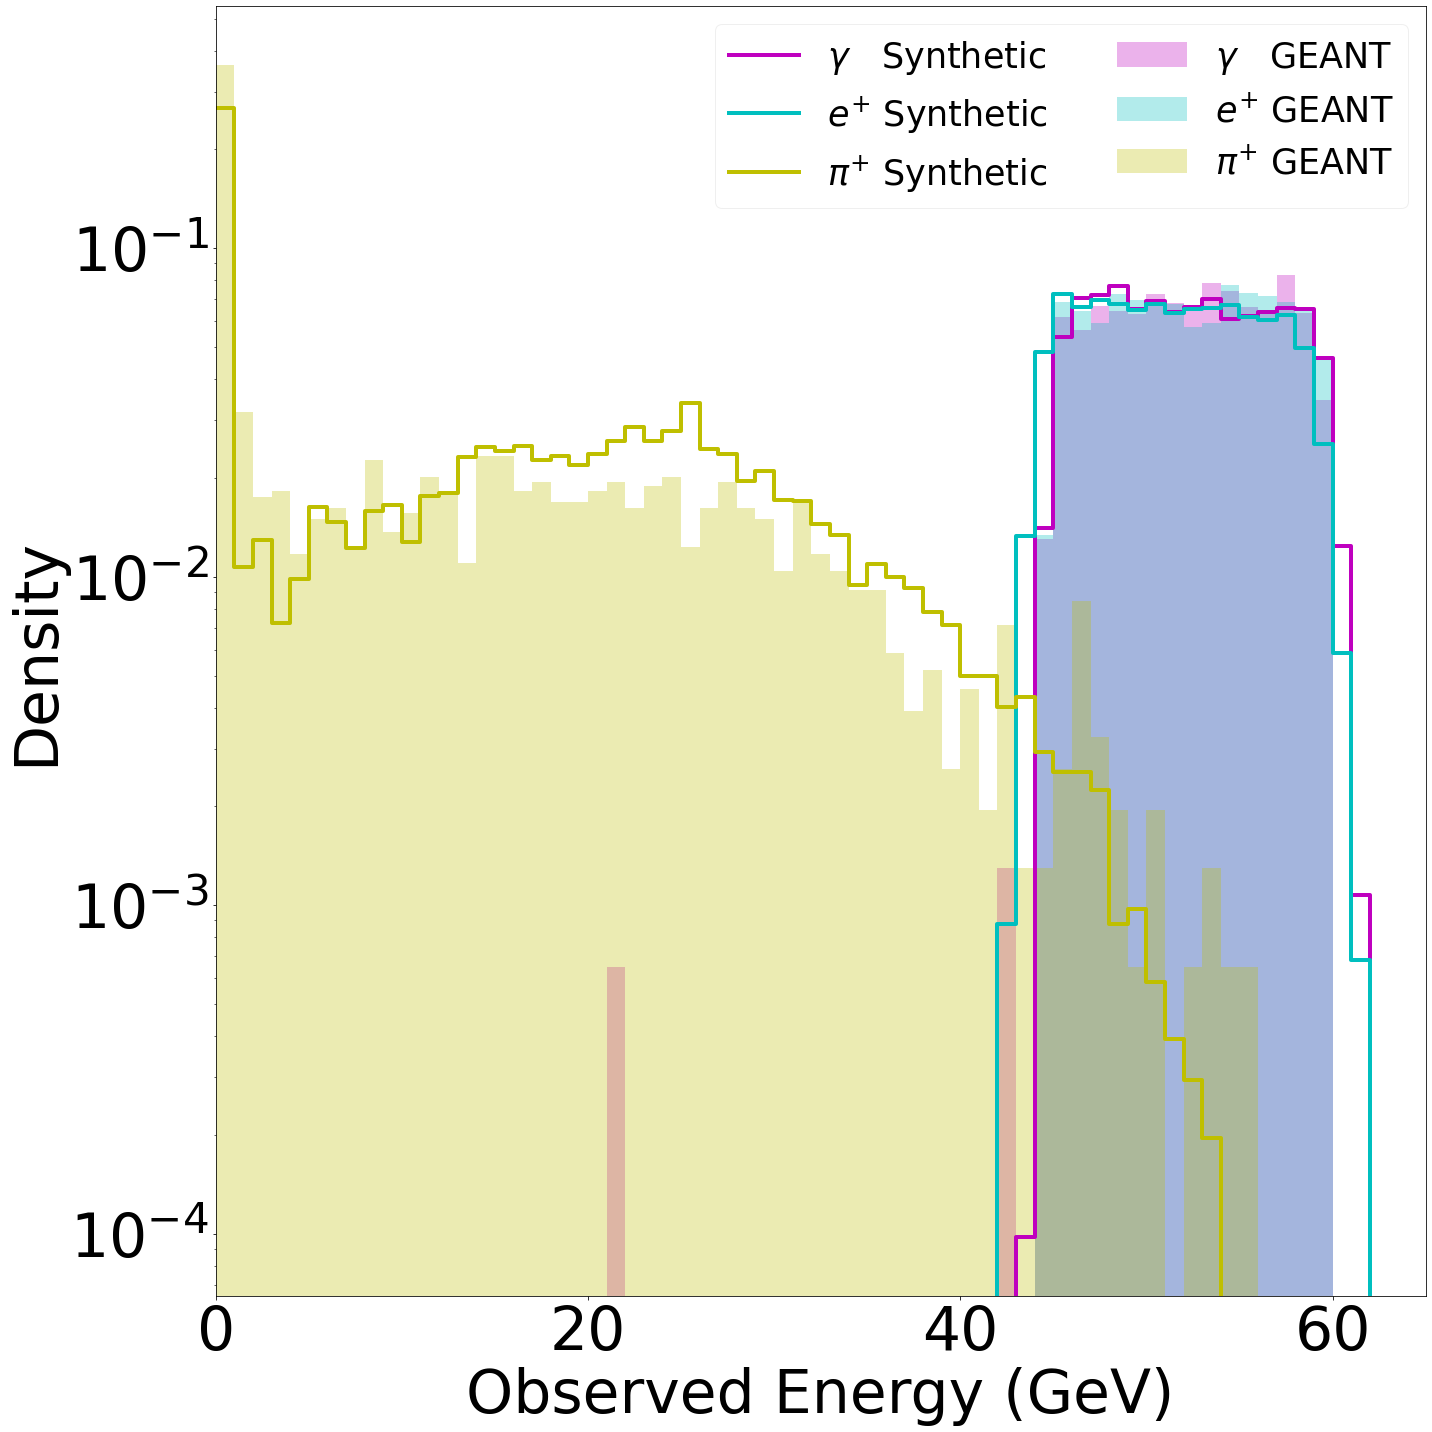

In [9]:
plot_sample_hist(p_types, p_paths, "sampleEnergyHist", "log", legend_loc="upper right", savefig=True)